In [1]:
%matplotlib inline

# import packages

import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import numpy as np
import sqlite3
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from pandas.io import sql
from matplotlib.ticker import ScalarFormatter

# load the raw data

# Select only the relevant columns
pop_cols = ['AGEP','SEX','HISP','POBP','RAC1P','SCIENGP','SOCP']

In [2]:
# Load in all of the ACS2013 data
df = pd.concat([pd.read_csv("ss13pusa.csv", usecols=pop_cols),
  pd.read_csv("ss13pusb.csv", usecols=pop_cols)])

In [3]:
df.head()

,AGEP,SEX,HISP,POBP,RAC1P,SCIENGP,SOCP
0,19,2,1,28,1,NaN,NaN
1,55,2,1,1,2,NaN,411011
2,56,1,1,1,2,NaN,493050
3,21,1,1,1,2,NaN,NaN
4,21,2,1,1,2,NaN,NaN


In [4]:
# Recode place of birth variable with state names
oldNewMap = {1: "Alabama", 2: "Alaska", 4: "Arizona", 5: "Arkansas", 6: "California",
8: "Colorado", 9: "Connecticut", 10: "Delaware", 11: "District_of_Columbia",
12: "Florida", 13: "Georgia", 15: "Hawaii", 16: "Idaho", 17: "Illinois", 18: "Indiana",
19: "Iowa", 20: "Kansas", 21: "Kentucky", 22: "Louisiana", 23: "Maine", 24: "Maryland",
25: "Massachusetts", 26: "Michigan", 27: "Minnesota", 28: "Mississippi", 29: "Missouri",
30: "Montana", 31: "Nebraska", 32: "Nevada", 33: "New_Hampshire", 34: "New_Mexico",
35: "New_Jersey", 36: "New_York", 37: "North_Carolina", 38: "North_Dakota", 39: "Ohio",
40: "Oklahoma", 41: "Oregon", 42: "Pennsylvania", 44: "Rhode_Island", 45: "South_Carolina",
46: "South_Dakota", 47: "Tennessee", 48: "Texas", 49: "Utah", 50: "Vermont", 51: "Virginia",
53: "Washington", 54: "West_Virginia", 55: "Wisconsin", 56: "Wyoming"}
df['State'] = df['POBP'].map(oldNewMap)

# recode sex variable
# First, change the integers that are used for coding.
# Right now, male = 1 and female = 2.
# to fit in a regression model they should be recoded to 0 and 1
if np.min(df['SEX']) > 0: #ensures that code won't be run if it's been recoded already
  df['SEX'] = df['SEX'] - 1
# Next, create a new column with Male/Female labels
oldNewMap = {0: "Male", 1: "Female"}
df['sex_recode'] = df['SEX'].map(oldNewMap)

# Recode race
# I will be using different categories than are used in the census data.
# All individuals of Hispanic origin will be categorized as Hispanic.
# Non-Hispanic White, Non-Hispanic Black and Asian will be included as categories.
# All other races are coded as "Other"
def race_recode(row):
  if row['HISP'] > 1:
    return "Hispanic"
  elif row['RAC1P'] == 1:
    return "White"
  elif row['RAC1P'] == 2:
    return "Black"
  elif row['RAC1P'] == 6:
    return "Asian"
  else:
    return "Other"
df['race_recode'] = df.apply(race_recode, axis=1)

# recode the HISP variable for easy readability
oldNewMap = {1: "Not Spanish/Hispanic/Latino", 2: "Mexican", 3: "Puerto Rican", 4: "Cuban", 
             5: "Dominican", 6: "Costa Rican", 7: "Guatemalan", 8: "Honduran", 9: "Nicaraguan",
            10: "Panamanian", 11: "Salvadorian", 12: "Other Central American", 13: "Argentinian",
            14: "Bolivian", 15: "Chilean", 16: "Colombian", 17: "Ecuadorian", 18: "Paraguayan",
            19: "Peruvian", 20: "Uruguayan", 21: "Venezuelan", 22: "Other South American",
            23: "Spaniard", 24: "All Other Spanish/Hispanic/Latino"}
df['detailed_hispanic_origin'] = df['HISP'].map(oldNewMap)

In [5]:
# Create STEM degree outcome variable
oldNewMap = {1: 1, 2: 0}
df['science_degree'] = df['SCIENGP'].map(oldNewMap)
df['science_degree'].fillna(value=0,inplace=True) # map doesn't include NA values, so they must be filled with zeroes

# Create STEM occupation outcome variable

science_job_codes = ['113021','119041','119121','151111','151121','151122','151131','151132','151133',
                          '151134','151141','151142','151143','151151','151152','151199','152011','152021',
                          '152031','152041','152099','171021','171022','172011','172021','172031','172041',
                          '172051','172061','172071','172072','172081','172111','172112','172121','172131',
                          '172141','172151','172161','172171','172199','173012','173013','173019','173021',
                          '173022','173023','173024','173025','173026','173027','173029','173031','191011',
                          '191012','191012','191021','191022','191023','191029','191031','191032','191041',
                          '191042','191099','192011','192012','192021','192031','192032','192041','192042',
                          '192043','192099','194011','194021','194031','194041','194051','194091','194092',
                          '194093','251021','251022','251032','251041','251042','251043','251051','251052',
                          '251053','251054','414011','419031']
df['science_occupation'] = df['SOCP'].isin(science_job_codes).astype(int)

In [7]:
# recode hispanic origin into 7 categories
oldNewMap = {1: "Not Spanish/Hispanic/Latino", 2: "Mexican", 3: "Puerto_Rican", 4: "Cuban", 
            5: "Other_Central_American", 6: "Other_Central_American", 7: "Other_Central_merican", 
            8: "Other_Central_American", 9: "Other_Central_American", 10: "Other_Central_American", 
            11: "Other_Central_American", 12: "Other_Central_American", 13: "South_American",
            14: "South_American", 15: "South_American", 16: "South_American", 17: "South_American", 
            18: "South_American", 19: "South_American", 20: "South_American", 21: "South_American", 
            22: "South_American", 23: "Spaniard", 24: "All_Other_Hispanic"}       
df['hisp_recode'] = df['HISP'].map(oldNewMap)

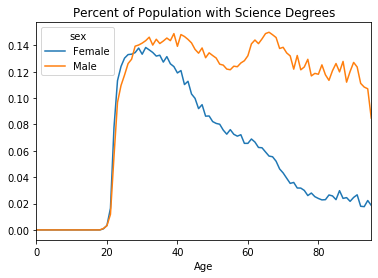

In [8]:
# Graph of science degree rates by age and sex
p = df.pivot_table(index='AGEP',values='science_degree',columns="sex_recode",
	aggfunc="mean")
p.columns.name = "sex"
p.index.name = 'Age'
p.plot(title='Percent of Population with Science Degrees')

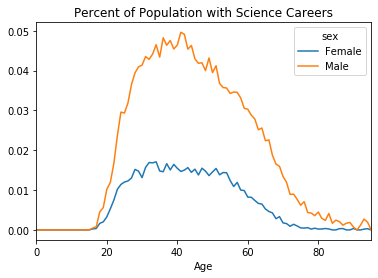

In [9]:
# Graph of STEM career rates by age and sex
p = df.pivot_table(index='AGEP',values='science_occupation',columns="sex_recode",
	aggfunc="mean")
p.columns.name = "sex"
p.index.name = 'Age'
p.plot(title='Percent of Population with Science Careers')

In [10]:
# add intercept for use in logistic regression model
df['intercept'] = 1.0

# add interaction term
df['sex_age'] = df['SEX'] * df['AGEP']

# dummy variables

# Pandas has a great function get_dummies that does all the work of
# creating dummy variables, and then you just have to join them.
# HOWEVER, this is memory intensive, so I will use a less memory intensive
# method of creating small tables for the dummy variables,
# and merging them using SQL

# state dummy variables
# Pennsylvania was omitted as the reference category due to its being
# a fairly large state that scored close to the average on outcome
states_to_include = ['Alabama','Alaska','Arizona','Arkansas','California',
                     'Colorado','Connecticut','Delaware','District_of_Columbia','Florida',
                     'Georgia','Hawaii','Idaho','Illinois','Indiana','Iowa',
                     'Kansas','Kentucky','Louisiana','Maine','Maryland','Massachusetts',
                     'Michigan','Minnesota','Mississippi','Missouri','Montana',
                     'Nebraska','Nevada','New_Hampshire','New_Jersey','New_Mexico',
                     'New_York','North_Carolina','North_Dakota','Ohio','Oklahoma',
                     'Oregon','Rhode_Island','South_Carolina','South_Dakota',
                     'Tennessee','Texas','Utah','Vermont','Virginia','Washington',
                     'West_Virginia','Wisconsin','Wyoming']
# create blank data frame (and add back Pennsylvania)
dummy_states = pd.DataFrame(index=(states_to_include+['Pennsylvania']),columns=states_to_include)
# for each state, when the index equals the column, include a 1
for state in states_to_include:
  dummy_states.set_value(state, state, 1)
# fill in zeroes for all other variables
dummy_states.fillna(value=0,inplace=True)

# Now, we do the same with race, using White as reference category

races_to_include = ['Black','Hispanic','Asian','Other']
dummy_race = pd.DataFrame(index=(races_to_include+['White']),columns=races_to_include)
for race in races_to_include:
  dummy_race.set_value(race, race, 1)
dummy_race.fillna(value=0,inplace=True)

# For Hispanic origin, Non-Hispanic is the reference category.
# In my final models, these will replace 'Hispanic' because they are more predictive.
# For some insight as to why different groups of Hispanics should not be treated
# as a single race in this model, I've covered that in another blog post:
# https://michaelinkles.wordpress.com/2016/03/12/whats-special-about-florida/
hisp_to_include = ['Mexican','Puerto_Rican','Cuban','Other_Central_American',
'South_American','Spaniard','All_Other_Hispanic']
dummy_hisp = pd.DataFrame(index=(hisp_to_include+['Not Spanish/Hispanic/Latino']),columns=hisp_to_include)
for hisp in hisp_to_include:
  dummy_hisp.set_value(hisp, hisp, 1)
dummy_hisp.fillna(value=0,inplace=True)

# To join the dummy variables, I created a SQLite database to store each table,
# then combined them into one big data frame using a SQL query

# Connect to SQLite
conn = sqlite3.connect('dat-test.db')

df.to_sql('df_main',con=conn,if_exists='replace',index=False)

dummy_states.to_sql('states',con=conn,if_exists='replace',index=True, index_label='State')

dummy_race.to_sql('races',con=conn,if_exists='replace',index=True, index_label='Race')

dummy_hisp.to_sql('hispanic_origins',con=conn,if_exists='replace',index=True, index_label='Hisp')

# In creating the final dataframe I'm using for the model,
# I want to subset out only people born in the 50 states or DC (so I can use State of Birth)
# who are over age 22 (so they are old enough to have a college degree)
# I could have done this earlier, but the most efficient way is to make it
# part of the SQL query that I'm doing anyway.
model_df = sql.read_sql(
"""
SELECT a.intercept, a.AGEP, a.SEX, a.sex_age, r.Asian, r.Black, r.Other, h.Mexican,
h.Puerto_Rican, h.Cuban, h.Spaniard, h.South_American, h.Other_Central_American, 
h.All_Other_Hispanic, s.Alabama, s.Alaska, s.Arizona, s.Arkansas, s.California,
s.Colorado, s.Connecticut,s.Delaware,s.District_of_Columbia,s.Florida,
s.Georgia,s.Hawaii,s.Idaho,s.Illinois,s.Indiana,s.Iowa,
s.Kansas,s.Kentucky,s.Louisiana,s.Maine,s.Maryland,s.Massachusetts,
s.Michigan,s.Minnesota,s.Mississippi,s.Missouri,s.Montana,
s.Nebraska,s.Nevada,s.New_Hampshire,s.New_Jersey,s.New_Mexico,
s.New_York,s.North_Carolina,s.North_Dakota,s.Ohio,s.Oklahoma,
s.Oregon,s.Rhode_Island,s.South_Carolina,s.South_Dakota,
s.Tennessee,s.Texas,s.Utah,s.Vermont,s.Virginia,s.Washington,
s.West_Virginia,s.Wisconsin,s.Wyoming, a.science_degree, a.science_occupation, a.POBP
FROM df_main as a
JOIN states as s
ON a.State = s.State
JOIN races as r
ON a.race_recode = r.Race
JOIN hispanic_origins as h
on a.hisp_recode = h.Hisp
WHERE a.AGEP > 22 and a.POBP < 60
""", con=conn)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:41: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:53: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [11]:
# Define degree model columns
train_cols_degree = ['intercept','AGEP','SEX','sex_age','Asian','Black','Other',
'Mexican','Puerto_Rican','Cuban','Spaniard','South_American',
'Other_Central_American','All_Other_Hispanic'] + states_to_include

# Fit degree model
lm_final_degree = LogisticRegression()
lm_final_degree.fit(model_df[train_cols_degree],model_df['science_degree'])

# Define occupation model columns
train_cols_occ = ['intercept','AGEP','SEX','sex_age','Asian','Black','Other',
'Mexican','Puerto_Rican','Cuban','Spaniard','South_American',
'Other_Central_American','All_Other_Hispanic']

# Subset only STEM degree holders for occupation model
df_degree = model_df[model_df['science_degree']==1]

# Fit occupation model
lm_final_occ = LogisticRegression()
lm_final_occ.fit(df_degree[train_cols_occ],df_degree['science_occupation'])

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [12]:
#IMPORTING LIBS################################################################

import time

from   datetime                import datetime                                #time

import numpy                   as     np                                      #data exploration

import pandas                  as     pd                                      #dataframes in python

import matplotlib.pyplot       as     plt                                     #plotting figs
import seaborn                 as     sns

import graphviz                                                               #plot trees
from   sklearn                 import preprocessing,model_selection           #crossval
from   sklearn.model_selection import train_test_split                        #To create test and train datasets
import itertools                                                              #to iterate easier on objects

from   xgboost                 import XGBClassifier                           #XGBoost classifier with sklearn wrapper               
import xgboost                 as     xgb                                     #XGBoost package class

from   sklearn                 import cross_validation,metrics                #Crossvalidation
from   sklearn.metrics         import confusion_matrix                        #Classic CM
from   sklearn.metrics         import accuracy_score,roc_auc_score,f1_score   #Relevant metrics
from   sklearn.metrics         import roc_curve,precision_recall_curve        #Curves
from   imblearn.over_sampling  import SMOTE                                   #SMOTE

from sklearn_evaluation import plot
from sklearn_evaluation import table

ModuleNotFoundError: No module named 'graphviz'

In [ ]:
#HELPER FUNCTIONS##############################################################

#Helper function 1: Fit the model to data using the AUC as a metric, showing iterations and printing a report

"""
*NOTE: 
This functions takes an XGBClassifier Object as input (with all the parameters and hyperparameters predefined) and will
only perform crossvalidation to better the chosen metric. AUC is used here but we can change it later. It also needs a 
predictors string list. Other parameters are optional.
"""

def modelfit(alg, dtrain, predictors, eval_set, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics=['logloss','auc'], early_stopping_rounds=early_stopping_rounds, verbose_eval = True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['target'], eval_metric = ['auc','logloss'], eval_set=eval_set)
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % accuracy_score(dtrain['target'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % roc_auc_score(dtrain['target'], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.get_booster().get_score(importance_type='weight')).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [ ]:
#Helper function 2: This one plots a nice looking confusion matrix
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
#    else:
#        print('Confusion matrix, without normalization')

#    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def show_data(cm, print_res = 0):
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    if print_res == 1:
        print('Precision =     {:.3f}'.format(tp/(tp+fp)))
        print('Recall (TPR) =  {:.3f}'.format(tp/(tp+fn)))
        print('Fallout (FPR) = {:.3e}'.format(fp/(fp+tn)))
    return tp/(tp+fp), tp/(tp+fn), fp/(fp+tn)

In [ ]:
#Helper function 3: This one gets the precision, recall and fallout curves given data, target and parameters

def get_curves(X_, y_, pars):
    X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size = 0.2)
    clf = xgb.XGBClassifier(**pars)
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_val)[:,clf.classes_[1]]
    fpr, tpr, thresholds_roc = roc_curve(y_val, y_prob)
    prec, rec, thresholds_pr = precision_recall_curve(y_val, y_prob)
    return fpr, tpr, prec, rec

#Helper function 4: This one generates the curves

def gen_curves(X_, y_, pars):
    N_iter = 300
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100000)
    
    mean_prec = 0.0
    mean_rec = np.linspace(0, 1, 100000)
    
    for n in range(N_iter):
        fpr, tpr, prec, rec = get_curves(X_, y_, pars)
        prec = list(reversed(prec)) #reverse, otherwise the interp doesn not work
        rec = list(reversed(rec))
        mean_tpr  += np.interp(mean_fpr, fpr, tpr)
        mean_prec += np.interp(mean_rec, rec, prec)

    mean_tpr /= N_iter
    mean_prec /= N_iter
    
    return mean_fpr, mean_tpr, mean_prec, mean_rec

#Helper function 5: This one plots the curves using the functions defined above

def plot_roc(X_, y_, par, name_par, list_par):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,14));
    for l in list_par:
        par[name_par] = l
        print(par)
        mean_fpr, mean_tpr, mean_prec, mean_rec = gen_curves(X_, y_, par)
        ax1.plot(mean_fpr, mean_tpr, label = name_par+" = "+str(l))
        ax2.plot(mean_rec, mean_prec, label = name_par+" = "+str(l))
    ax1.set_xlim([0, 0.0005])
    ax1.set_ylim([0.6, 0.85])
    ax1.axvline(2e-4, color='b', linestyle='dashed', linewidth=2)
    ax1.legend(loc="lower right")
    ax1.set_xlabel('FPR/Fallout')
    ax1.set_ylabel('TPR/Recall')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax1.set_title('ROC')
    ax2.set_title('PR')
    ax2.legend(loc = "lower left")
    ax2.set_xlim([0.75, 0.95])
    plt.show()
    
from sklearn.metrics import classification_report

target_names = ['Healthy', 'Defaulting']